In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from tqdm import tqdm
from datetime import datetime, timedelta
from winsound import Beep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [23]:
# 獲取數據
df_NQTXF = pd.read_parquet("datas/混合NQTXF.pqt", engine="fastparquet")
# 提取Close_TXF和Close_NQ列
stock1 = df_NQTXF["Close_TXF"]
stock2 = df_NQTXF["Close_NQ"]

# # 計算每月的比例
# monthly_ratio = stock1.resample("D").mean() / stock2.resample("D").mean()
# 設定重置時間
monthly_ratio = (
    # stock1.resample("M", offset="15H").first()
    stock1.resample("2H", offset="0H").first()
    - stock2.resample("2H", offset="0H").first()
)

# 將比例應用到每日數據
monthly_ratio = monthly_ratio.reindex(stock1.index, method="ffill")

# 調整股票價格
adjusted_stock1 = stock1 - monthly_ratio  # / monthly_ratio

# 計算調整後的spread
adjusted_spread = adjusted_stock1 - stock2

###########如果要自我迴歸
# adjusted_spread =stock1 - stock1.resample("H", offset="0min").first().reindex(stock1.index, method="ffill") #adjusted_stock1 - stock2
# adjusted_spread.index = pd.to_datetime(adjusted_spread.index)


In [24]:
########如果要配對交易
df = pd.DataFrame(adjusted_spread, columns=["adjusted_spread"])
########如果要自我迴歸
# df = pd.DataFrame(adjusted_spread, columns=["adjusted_spread"])
# Rename columns
# df = df.rename(columns={'Close_TXF': 'adjusted_spread'})
# df = pd.DataFrame(adjusted_spread, columns=["adjusted_spread"])
df.to_parquet("datas/混合NQTXF的價差-時間關係_1比1_2H.pqt")


# Round the adjusted_spread to integers
df["adjusted_spread"] = (df["adjusted_spread"] / 1).round().astype(int) * 1

# Filter the DataFrame for the time range from 15:00:00 to 09:00:00 of the next day
# 去除 13:30 ~ 13:45 的交易
initialing_start_time = "15:00:00"
initialing_end_time = "13:30:00"
df_filtered = df.between_time(initialing_start_time, initialing_end_time)

# Count the occurrences of each rounded adjusted_spread value for each time
df_filtered["Time"] = df_filtered.index.time
result = df_filtered.groupby(["Time", "adjusted_spread"]).size().unstack(fill_value=0)

# Create a new index with the desired order of times
new_index = pd.date_range(
    start="2022-08-22 15:00:00", end="2022-08-23 13:30:00", freq="5min"
).time

# Reindex the DataFrame with this new index
result = result.reindex(new_index)
# result就是每天的這個時間點 出現過的價差次數

# Function to expand the DataFrame
def expand_row(row):
    expanded = []
    for spread, count in row.items():
        if spread not in ['Time','adjusted_spread'] :
            count = 0 if pd.isna(count) else int(count)
            expanded.extend([int(spread)] * count)
    return expanded

# Expand the DataFrame
expanded_data = []
for index, row in result.iterrows():
    expanded_data.append(expand_row(row))

# Calculate mean and standard deviation
spread_std_dev=[]
spread_mean = []
spread_mean.extend(np.mean(i) for i in expanded_data)
spread_std_dev.extend(np.std(i) for i in expanded_data)

# 用上面正確的部分來整合
統計結果_df=pd.DataFrame(result)
# 這裡是如何計算每個時間點的標準差和平均值

# 計算每個時間點的平均值
mean_values = spread_mean

# 計算每個時間點的標準差
std_values = spread_std_dev

# 將結果添加到 DataFrame 中
統計結果_df['mean'] = mean_values
統計結果_df['std'] = std_values

統計結果std_df=pd.DataFrame(統計結果_df["std"])
統計結果std_df=統計結果std_df.reset_index()

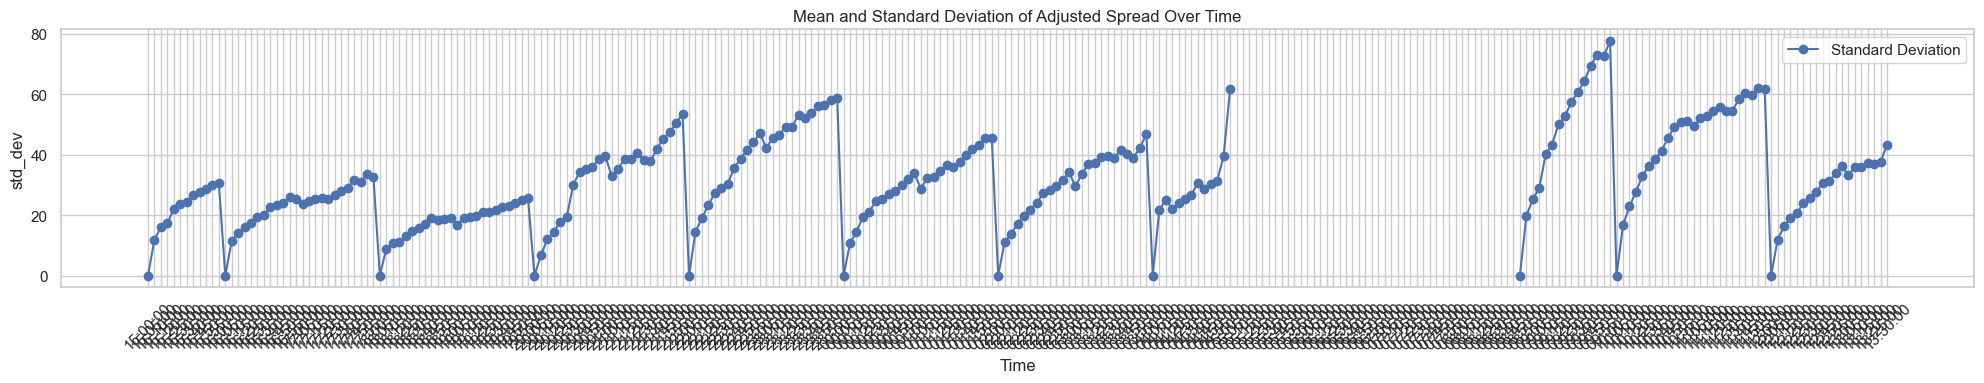

In [25]:
# %matplotlib qt 
%matplotlib inline 
# 設置圖表風格
sns.set(style="whitegrid")

# 繪製spread圖表
plt.figure(figsize=(20, 4))

# 繪製標準差
plt.plot(統計結果_df.index.astype(str), 統計結果_df['std'], marker='o', label='Standard Deviation')

# 添加標題和標籤
plt.title('Mean and Standard Deviation of Adjusted Spread Over Time')
plt.xlabel('Time')
plt.ylabel('std_dev')
plt.legend()

# 顯示圖形
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

1H ,offset 0 ↓
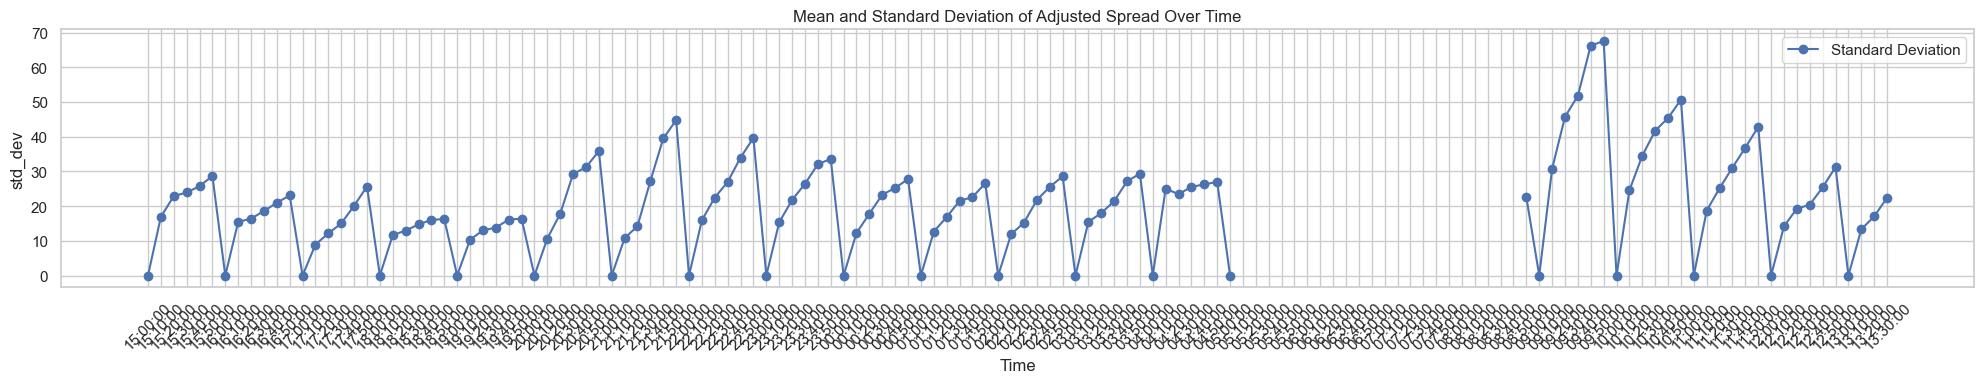

In [26]:
# 最後一步整合回測資料 方便回測
原始資料_df=pd.DataFrame(df)
原始資料_df.index = pd.to_datetime(原始資料_df.index)

# Filter the DataFrame to keep the index within the specified time range
initialing_start_time = "15:00:00"
initialing_end_time = "13:30:00"

# Create a mask to filter the DataFrame
mask = (原始資料_df.index.time >= pd.to_datetime(initialing_start_time).time()) | (原始資料_df.index.time <= pd.to_datetime(initialing_end_time).time())
原始資料_df = 原始資料_df[mask]

原始資料_df['Time']=原始資料_df.index.time
原始資料_df=原始資料_df.reset_index()


# Merge the dataframes on the 'Time' column
merged_df = pd.merge(原始資料_df, 統計結果std_df, on='Time', how='left').ffill().bfill()
merged_df = merged_df.set_index('Datetime')

In [27]:
#排除vix過大的時候
#獲取數據
vix = yf.download("^VIX", start="2018-01-01", end="2024-08-27")["Close"]
# 萬一row不一樣多的時候
vix = pd.DataFrame(vix)
vix = vix.reindex(merged_df.index, method="ffill")

# 刪除VIX大於20的日資料
merged_noVIX_df = merged_df[vix["Close"] <= 40]
# merged_noVIX_df

[*********************100%%**********************]  1 of 1 completed


回測預設條件 

In [63]:
def available_time(time_list,delta1,delta2):
    time_ranges = []
    for time_str in time_list:
        start_time = (pd.to_datetime(time_str)+ pd.Timedelta(minutes=delta1))#.strftime('%H:%M:%S')
        end_time = (pd.to_datetime(time_str) + pd.Timedelta(minutes=delta2))#.strftime('%H:%M:%S')
        time_ranges.append((start_time, end_time))
    # 再從timestamp換成date_time
    time_ranges = [(pd.to_datetime(start).time(), pd.to_datetime(end).time()) for start, end in time_ranges]
    # 向量化時間檢查
    times = merged_noVIX_df.index.time
    all_time_ranges = np.zeros(len(times), dtype=bool)

    for start_time, end_time in time_ranges:
        # 把所有可以的時間合併起來
        all_time_ranges |= (times >= start_time) & (times <= end_time)
    # 再從nd_array換成dataframe
    # all_time_ranges = pd.DataFrame(all_time_ranges)
    # all_time_ranges = pd.Series(all_time_ranges)
    return all_time_ranges

# 這裡調整交易時間
good_time_arr=[ #19,23賺 #11不賺
    # '11:00:00',    
    '16:00:00',    '18:00:00',    '20:00:00', '22:00:00', 
    '00:00:00',    '02:00:00'
    ]
is_start_time = available_time(good_time_arr,0,4)
is_buy_time=available_time(good_time_arr,5,80)
is_sell_time=available_time(good_time_arr,5,114)
is_settle_time = available_time(good_time_arr,115,119)
# 檢查今天是否是星期一到星期四 (週五晚上~週一的資料會莫名消失 所以用此方法閃避這個問題)
weekdays = merged_noVIX_df.index.weekday
is_trade_day = (weekdays >= 0) & (weekdays <= 3)  # 0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday

回測主體

In [104]:
#手續5
# 獲利 /開倉次數
# 1252  / 2153 [1.2, 2.4, 10, 1000]
# 2236  / 2204 [1.2, 2, 10, 1000]
# 2856  / 2652 [1, 2, 10, 1000]
# 4431  / 2926 [1, 1, 10, 1000]
# 1013  / 3089 [0.8, 2, 10, 1000]
# 3479  / 2406 [0.8, 1.6, 20, 1000]
# 4576  / 2861 [0.8, 1.6, 15, 1000]
# 3152  / 3232 [0.8, 1.6, 10, 1000]
# 2891  / 3493 [0.8, 1.6, 6, 1000]
# 4501  / 3720 [0.8, 0.8, 10, 1000]

# 初始化欄位：設定初始的 margin、stop_loss_triggered、position 和 pnl 欄位。

#參數關鍵: 最少50 不停損 收雙倍std 進場std偏小(低於3)
parameter_arrs=[
    [1.2,2.4,10,1000],
    [1.2,2,10,1000],
    [1,2,10,1000],
    [1,1,10,1000],
    [0.8,2,10,1000],
    [0.8,1.6,20,1000],
    [0.8,1.6,15,1000],
    [0.8,1.6,10,1000],
    [0.8,1.6,6,1000],
    [0.8,0.8,10,1000]
]

for parameter_arr in (parameter_arrs):
    g_進場std, g_收復std, g_可賺價差 , g_停損值 = parameter_arr
    merged_noVIX_df['margin'] = 0.0
    merged_noVIX_df['stop_loss_triggered'] = False
    merged_noVIX_df['position'] = 0
    merged_noVIX_df['pnl'] = 0
    merged_noVIX_df['time']= merged_noVIX_df.index
    #設定進場要幾倍標準差
    進場n倍_std=g_進場std
    #設定出場獲利要有幾倍標準差
    收復n倍_std=g_收復std
    手續費 = 3
    # 初始化變數：設定初始的 margin、position、entry_price、stop_loss_triggered 和 pnl 變數。
    margin = 0.0
    position = 0  # 1 表示多頭，-1 表示空頭，0 表示無持倉
    entry_price = 0.0
    entry_time = pd.NaT
    hold_time = pd.NaT
    stop_loss_triggered = False
    pnl = 0

    # Precompute conditions to avoid repeated DataFrame lookups
    adjusted_spread_values = merged_noVIX_df['adjusted_spread'].values
    std_values = merged_noVIX_df['std'].values
    time_values = merged_noVIX_df['time']

    margins = np.zeros(len(merged_noVIX_df))
    positions = np.zeros(len(merged_noVIX_df))
    pnls = np.zeros(len(merged_noVIX_df))
    stop_loss_triggers = np.zeros(len(merged_noVIX_df), dtype=bool)

    # 模擬配對交易：使用迴圈模擬配對交易，根據不同的時間段和條件來更新 margin、position 和 pnl。
    for i in (range(1, len(merged_noVIX_df))):
        if is_start_time[i]:
            # g_進場std, g_收復std, g_可賺價差 , g_停損值 = [1,1,10,80]
            stop_loss_triggered = False
            position = 0
        elif is_settle_time[i]:
            if position != 0:
                stop_loss_triggered = False
                pnl = (adjusted_spread_values[i] - entry_price) * position
                margin += (pnl- 手續費)
                margins[i] = margin
                position = 0
        elif is_sell_time[i] and is_trade_day[i] and ~stop_loss_triggered:
            # if stop_loss_triggered:
                # 如果停損，該場次就在更遠的地方才進場
                # g_進場std, g_收復std, g_可賺價差 , g_停損值 = [1.5,1.5,10,100]
                # continue 
            if position == 0 and is_buy_time[i] and abs(adjusted_spread_values[i]) > g_可賺價差:
                if adjusted_spread_values[i] > std_values[i] * 進場n倍_std:
                    position = -1
                    entry_price = adjusted_spread_values[i]
                    # entry_time = time_values[i]
                elif adjusted_spread_values[i] < -std_values[i] * 進場n倍_std:
                    position = 1
                    entry_price = adjusted_spread_values[i]
                    entry_time = time_values[i]
            elif position != 0 :
                pnl = (adjusted_spread_values[i] - entry_price) * position
                hold_time = time_values[i] - entry_time
                if pnl <= -g_停損值:
                    margin += (pnl - 手續費)
                    margins[i] = margin
                    position = 0
                    stop_loss_triggered = True
                elif pnl > std_values[i] * 收復n倍_std:
                    margin += (pnl - 手續費)
                    margins[i] = margin
                    position = 0
                # elif hold_time > np.timedelta64(75, 'm') :
                #     g_進場std, g_收復std, g_可賺價差 , g_停損值 = [1,1,10,100]
                    # margin += (pnl - 手續費)
                    # merged_noVIX_df.at[merged_noVIX_df.index[i], 'margin'] = margin
                    # position = 0
                    # stop_loss_triggered = True
        pnls[i] = pnl
        positions[i] = position
        stop_loss_triggers[i] = stop_loss_triggered
        
    merged_noVIX_df['margin'] = margins
    merged_noVIX_df['position'] = positions
    merged_noVIX_df['pnl'] = pnls
    merged_noVIX_df['stop_loss_triggered'] = stop_loss_triggers
    # 延續 margin：使用 ffill 方法來延續 margin 欄位的值。這樣畫圖時，週六日就不會瞬間歸零
    merged_noVIX_df['margin'] = merged_noVIX_df['margin'].replace({0: np.nan})
    merged_noVIX_df['margin'] = merged_noVIX_df['margin'].ffill()
    # print("獲利點數：",merged_noVIX_df.iloc[-1]['margin'])
    # Initialize the "in_out" column with 0
    merged_noVIX_df['in_out'] = 0

    # Create a shifted column
    merged_noVIX_df['shifted_position'] = merged_noVIX_df['position'].shift()

    # Calculate the "in_out" column using vectorized operations
    merged_noVIX_df.loc[(merged_noVIX_df['position'] != 0) & (merged_noVIX_df['shifted_position'] == 0), 'in_out'] = 1
    merged_noVIX_df.loc[(merged_noVIX_df['position'] == 0) & (merged_noVIX_df['shifted_position'] != 0), 'in_out'] = -1

    ones_times = merged_noVIX_df[merged_noVIX_df['in_out'] == 1].index.time
    # print("總開倉次數:", len(ones_times))
    print(int(merged_noVIX_df.iloc[-1]['margin']) ," /",len(ones_times),[g_進場std, g_收復std, g_可賺價差 , g_停損值])
    '''
    if 1:
        # 單圖
        # %matplotlib qt 
        %matplotlib inline 

        # Creating the figure and the first subplot
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
        fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))

        # Plotting the first set of data
        ax1.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
        ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
        ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')

        # Adding titles and labels to the first plot
        ax1.set_title('Adjusted Spread and Standard Deviation Over Time')
        ax1.set_xlabel('Datetime')
        ax1.set_ylabel('Values')
        ax1.legend()

        # Creating a second y-axis for the 'margin' data
        ax2 = ax1.twinx()
        ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='Margin', color='green')

        # Adding labels to the second y-axis
        ax2.set_ylabel('Margin')
        ax2.legend(loc='upper right')
        plt.grid(True)
        # Adjusting layout and displaying the plots
        plt.tight_layout()
        plt.show()
    '''
    Beep(8000,300)



1252  / 2153 [1.2, 2.4, 10, 1000]
2236  / 2204 [1.2, 2, 10, 1000]
2856  / 2652 [1, 2, 10, 1000]
4431  / 2926 [1, 1, 10, 1000]
1013  / 3089 [0.8, 2, 10, 1000]
3479  / 2406 [0.8, 1.6, 20, 1000]
4576  / 2861 [0.8, 1.6, 15, 1000]
3152  / 3232 [0.8, 1.6, 10, 1000]
2891  / 3493 [0.8, 1.6, 6, 1000]
4501  / 3720 [0.8, 0.8, 10, 1000]


績效回報

In [69]:

# Initialize the "in_out" column with 0
merged_noVIX_df['in_out'] = 0

# Create a shifted column
merged_noVIX_df['shifted_position'] = merged_noVIX_df['position'].shift()

# Calculate the "in_out" column using vectorized operations
merged_noVIX_df.loc[(merged_noVIX_df['position'] != 0) & (merged_noVIX_df['shifted_position'] == 0), 'in_out'] = 1
merged_noVIX_df.loc[(merged_noVIX_df['position'] == 0) & (merged_noVIX_df['shifted_position'] != 0), 'in_out'] = -1


In [45]:
merged_noVIX_df.to_csv("datas/NQTXF-回測報告_漣漪法_優化後.csv")

In [68]:

df = pd.DataFrame(merged_noVIX_df)

# Calculate each 1's appear time in a day
ones_times = df[df['in_out'] == 1].index.time

# Calculate the average and standard deviation distance of each 1
ones_indices = df[df['in_out'] == 1].index
ones_distances = ones_indices.to_series().diff().dropna().dt.total_seconds() / 60  # Convert to minutes
avg_distance_1 = ones_distances.mean()
std_distance_1 = ones_distances.std()

# Calculate the average and standard deviation of 1 and next -1's distance
ones_positions = df[df['in_out'] == 1].index
minus_ones_positions = df[df['in_out'] == -1].index

distances_1_to_minus1 = []
for one_pos in ones_positions:
    next_minus1 = minus_ones_positions[minus_ones_positions > one_pos]
    if not next_minus1.empty:
        distance = (next_minus1[0] - one_pos).total_seconds() / 60  # Convert to minutes
        if distance<150:
            distances_1_to_minus1.append(distance) 


avg_distance_1_to_minus1 = np.mean(distances_1_to_minus1)
std_distance_1_to_minus1 = np.std(distances_1_to_minus1)

# Output the results
print("總開倉次數:", len(ones_times))
print("每個1之間的 平均 分鐘:", avg_distance_1)
print("每個1之間的 標準差 分鐘:", std_distance_1)
print("1 到下一個 -1的 平均 分鐘:", avg_distance_1_to_minus1)
print("1 到下一個 -1的 標準差 分鐘:", std_distance_1_to_minus1)


總開倉次數: 2926
每個1之間的 平均 分鐘: 804.0557264957265
每個1之間的 標準差 分鐘: 2156.752670896412
1 到下一個 -1的 平均 分鐘: 62.298401420959145
1 到下一個 -1的 標準差 分鐘: 39.971985495378746


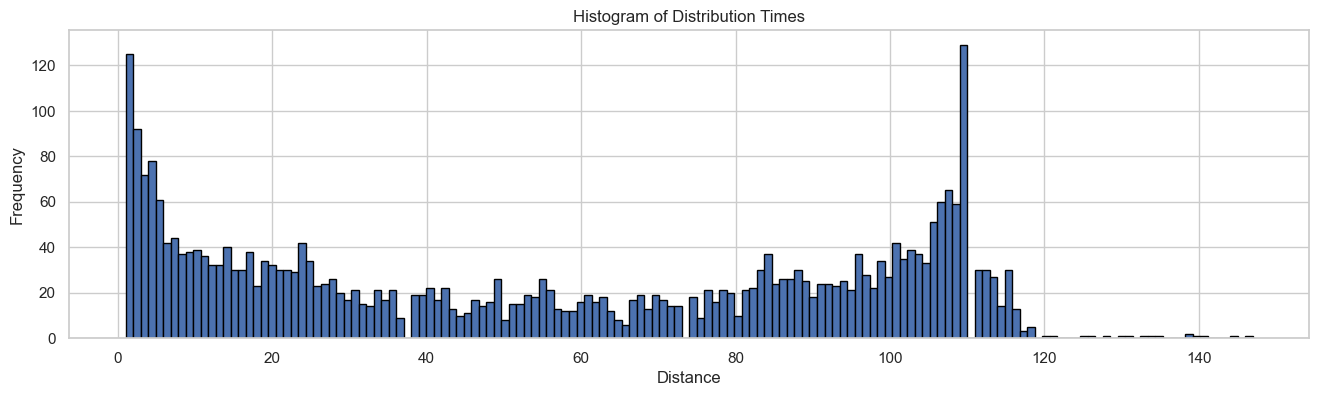

In [47]:
# %matplotlib qt 
%matplotlib inline 
# 持倉時間長度
plt.figure(figsize=(16, 4))
# Plotting the histogram
plt.hist(distances_1_to_minus1, bins=150, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Distribution Times')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [48]:
# 分析持倉時間與獲利
df = pd.DataFrame(merged_noVIX_df)
# 挑出所有進出場記錄
df_filtered = df[df['in_out'].isin([-1, 1])]

# Convert 'time' column to datetime
df_filtered['time'] = pd.to_datetime(df_filtered['time'])
df_filtered['time'] = df_filtered['time'].apply(lambda x: datetime.combine(datetime.today(), x.time()))

# Create a column for the previous 'in' time
df_filtered['prev_time'] = df_filtered['time'].shift()

# Calculate the time difference only for 'out' rows
df_filtered['time_pass'] = (df_filtered['time'] - df_filtered['prev_time']).where(df_filtered['in_out'] == -1).dt.total_seconds() / 60

# Drop the 'prev_time' column as it's no longer needed
df_filtered.drop(columns=['prev_time'], inplace=True)

# print(df_filtered)
# print(df_filtered.iloc[1]['time'])
# print(df_filtered.iloc[2]['time'])
# print(df_filtered.iloc[2]['time']-df_filtered.iloc[1]['time'])
# for i, row in df.iterrows():
#     if row['in_out'] == -1:
#         print(row['time'])
#         break
df_filtered

,adjusted_spread,Time,std,margin,stop_loss_triggered,position,pnl,time,in_out,shifted_position,time_pass
Datetime,,,,,,,,,,,
2020-02-25 08:45:00,0,08:45:00,0.000000,NaN,False,0.0,0.0,2024-09-04 08:45:00,-1,NaN,NaN
2020-02-25 16:42:00,25,16:42:00,23.393579,NaN,False,-1.0,0.0,2024-09-04 16:42:00,1,0.0,NaN
2020-02-25 17:55:00,41,17:55:00,32.472449,-16.0,False,0.0,-16.0,2024-09-04 17:55:00,-1,-1.0,73.0
2020-02-25 18:18:00,12,18:18:00,11.124733,-16.0,False,-1.0,-16.0,2024-09-04 18:18:00,1,0.0,NaN
2020-02-25 19:55:00,0,19:55:00,25.628599,-4.0,False,0.0,12.0,2024-09-04 19:55:00,-1,-1.0,97.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-15 20:12:00,3,20:12:00,11.980343,12773.0,False,0.0,17.0,2024-09-04 20:12:00,-1,1.0,7.0
2024-08-15 20:15:00,26,20:15:00,14.484736,12773.0,False,-1.0,17.0,2024-09-04 20:15:00,1,0.0,NaN
2024-08-15 21:55:00,105,21:55:00,53.523633,12694.0,False,0.0,-79.0,2024-09-04 21:55:00,-1,-1.0,100.0


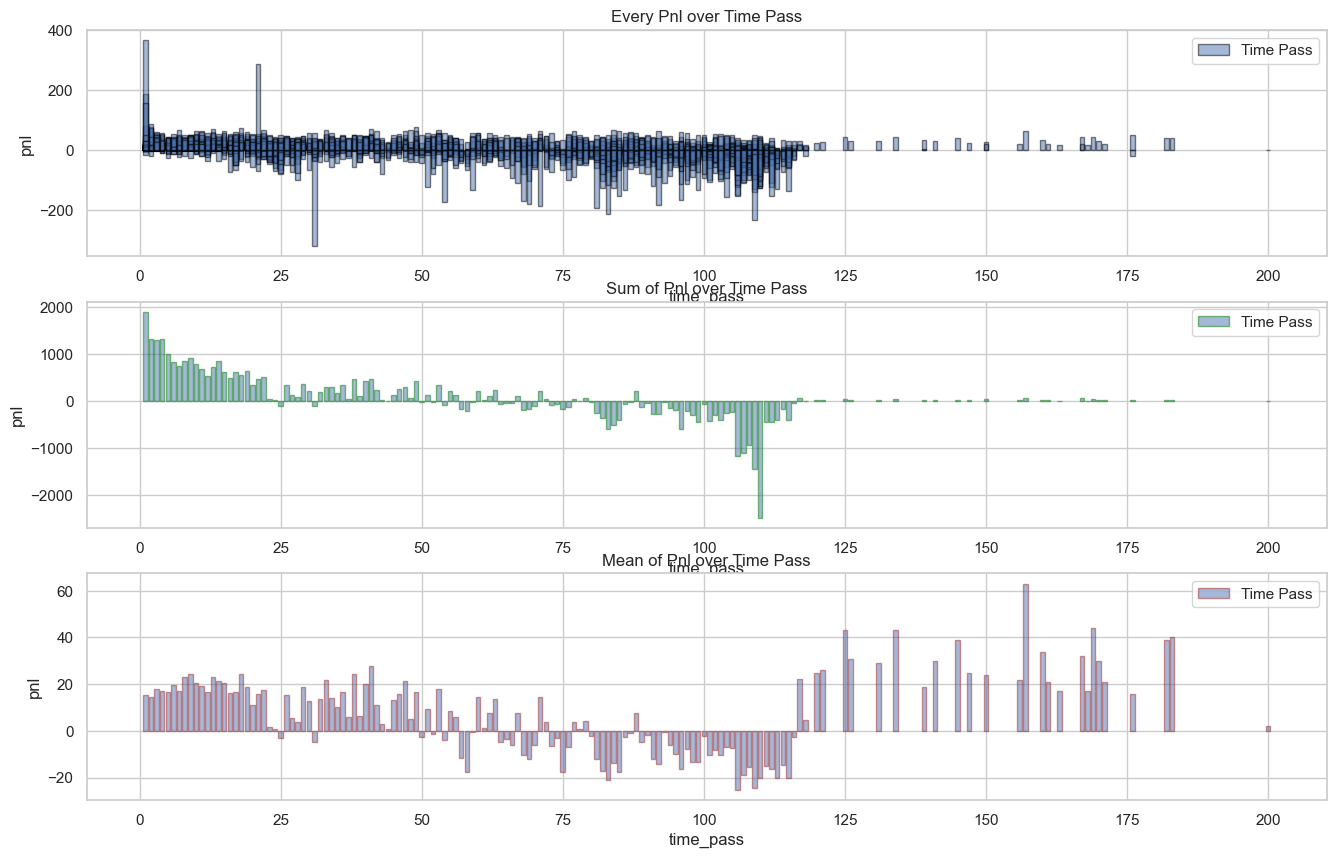

In [49]:
# 持倉時間與獲利
# %matplotlib qt 
%matplotlib inline 
# Convert times to minutes for histogram
# Remove rows with NaN in 'time_pass'
df_filtered_removeNAN = df_filtered.dropna(subset=['time_pass'])
# Then, drop rows where 'time_pass' is greater than 200
df_filtered_removeNAN = df_filtered_removeNAN[df_filtered_removeNAN['time_pass'] <= 200]
df_filtered_removeNAN = df_filtered_removeNAN[df_filtered_removeNAN['time_pass'] >= 0]
# Group by 'time_pass' and calculate the average 'pnl'
df_filtered_sum = df_filtered_removeNAN.groupby('time_pass')['pnl'].sum().reset_index()
df_filtered_average = df_filtered_removeNAN.groupby('time_pass')['pnl'].mean().reset_index()
# Plotting histogram
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(16, 10))
# plt.figure(figsize=(16, 6))
ax1.bar(df_filtered_removeNAN['time_pass'],df_filtered_removeNAN['pnl'], alpha=0.5, label='Time Pass', edgecolor='black')
ax1.set_title('Every Pnl over Time Pass')
ax1.set_xlabel('time_pass')
ax1.set_ylabel('pnl')
ax1.legend(loc='upper right')

ax2.bar(df_filtered_sum['time_pass'],df_filtered_sum['pnl'], alpha=0.5, label='Time Pass', edgecolor='green')
ax2.set_title('Sum of Pnl over Time Pass')
ax2.set_xlabel('time_pass')
ax2.set_ylabel('pnl')
ax2.legend(loc='upper right')

ax3.bar(df_filtered_average['time_pass'],df_filtered_average['pnl'], alpha=0.5, label='Time Pass', edgecolor='brown')
ax3.set_title('Mean of Pnl over Time Pass')
ax3.set_xlabel('time_pass')
ax3.set_ylabel('pnl')
ax3.legend(loc='upper right')

plt.grid(True)
plt.show()

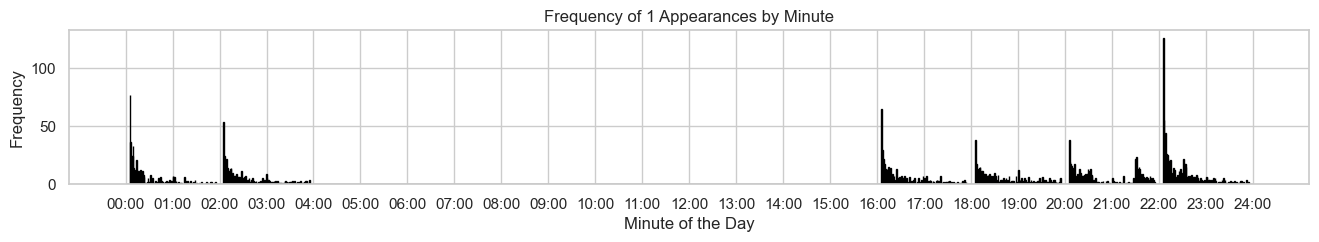

In [50]:
# 進場時間
# %matplotlib qt 
%matplotlib inline 
# Convert times to minutes for histogram
times_in_minutes = [t.hour * 60 + t.minute + t.second / 60 for t in ones_times]

# Plot histogram
plt.figure(figsize=(16, 2))
plt.hist(times_in_minutes, bins=1440, range=(0, 1440), edgecolor='black')
plt.xlabel('Minute of the Day')
plt.ylabel('Frequency')
plt.title('Frequency of 1 Appearances by Minute')
plt.xticks(np.arange(0, 1441, 60), labels=[f'{i//60:02d}:00' for i in range(0, 1441, 60)])
plt.grid(True)
plt.show()

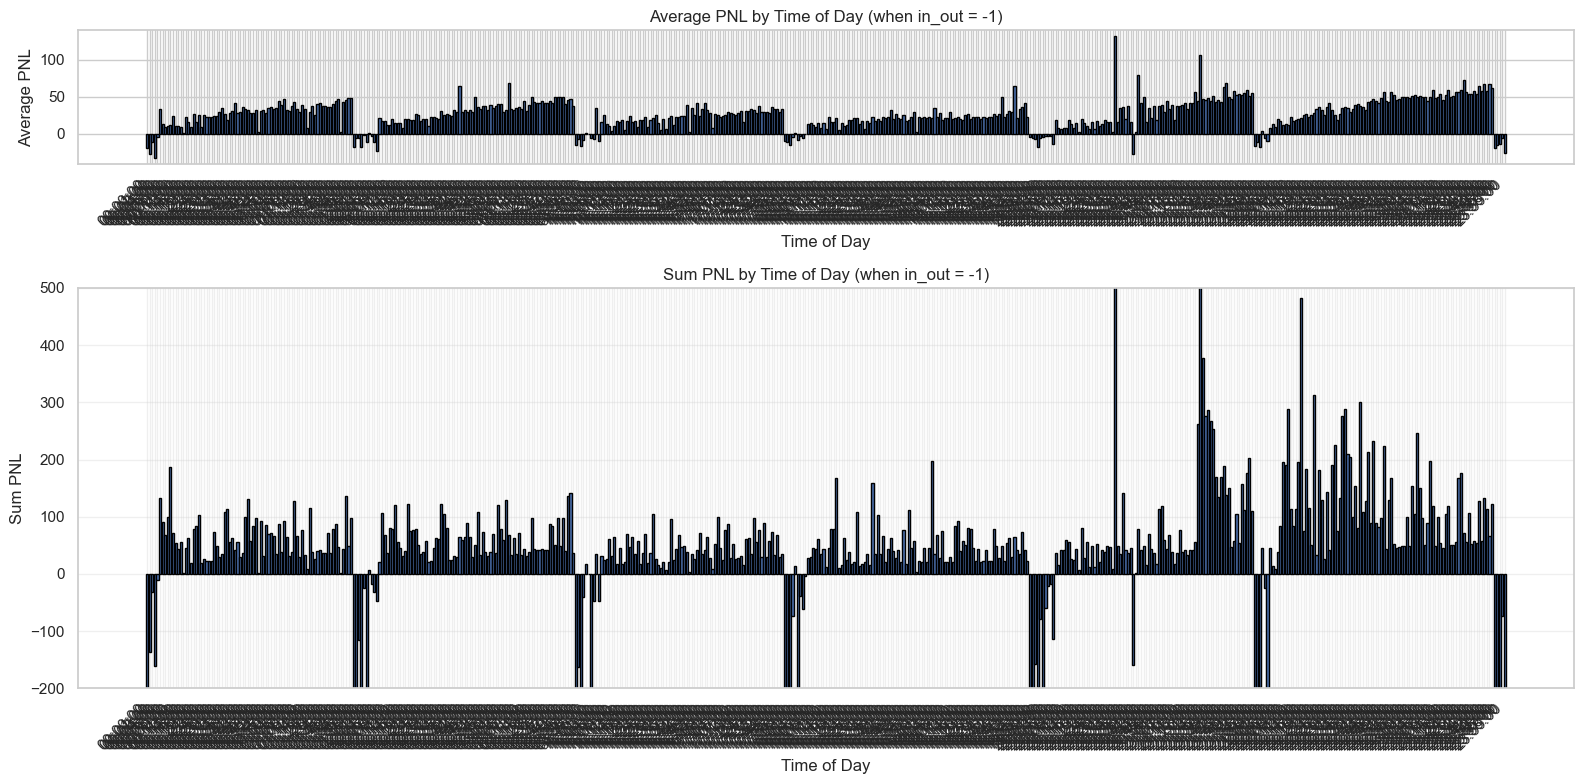

In [61]:
# 出場時間與獲利
df = pd.DataFrame(merged_noVIX_df)
# Extract the time component from the index
df['time'] = df.index.time

# Filter the DataFrame for rows where 'in_out' is -1
df_filtered = df[df['in_out'] == -1]

# Group by time and calculate the mean and sum 'pnl'
average_pnl = df_filtered.groupby('time')['pnl'].mean()
sum_pnl = df_filtered.groupby('time')['pnl'].sum()

# Convert time to string for better x-axis labels
average_pnl.index = average_pnl.index.astype(str)
sum_pnl.index = sum_pnl.index.astype(str)

# Plotting
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 3]})

# Average PNL by Time of Day
ax1.bar(average_pnl.index, average_pnl, edgecolor='black')
ax1.set_title('Average PNL by Time of Day (when in_out = -1)')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Average PNL')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Sum PNL by Time of Day
ax2.bar(sum_pnl.index, sum_pnl, edgecolor='black')
ax2.set_title('Sum PNL by Time of Day (when in_out = -1)')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Sum PNL')
ax2.set_ylim(top=500, bottom=-200)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()


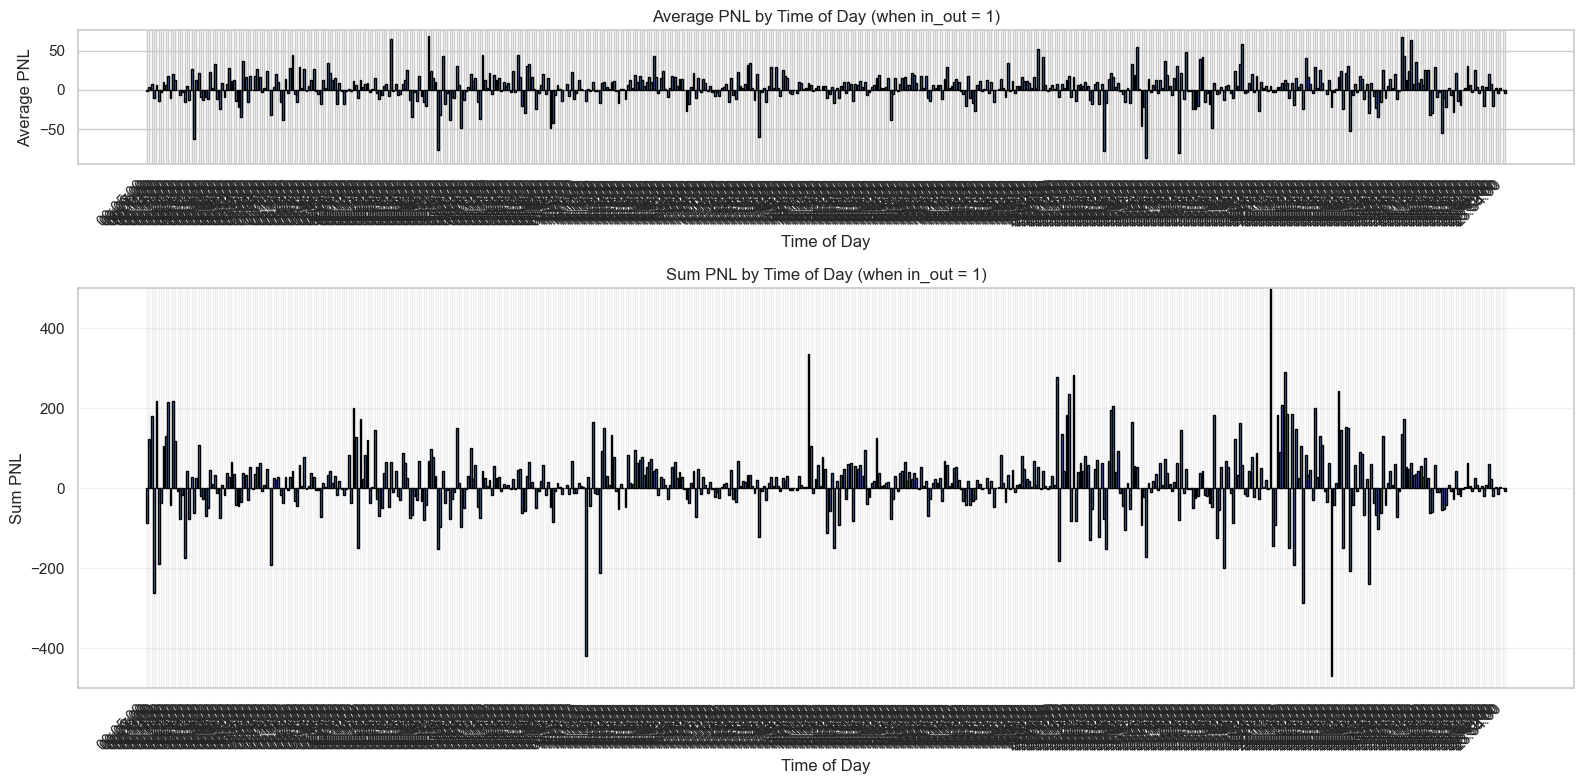

In [52]:
# 進場時間與獲利
df = pd.DataFrame(merged_noVIX_df)
# 挑出所有進出場記錄
df_filtered = df[df['in_out'].isin([-1,1])]
#######
# Shift the 'pnl' values where 'in_out' is -1(讓分身搭電梯上去給他複製)
df_filtered['shifted_pnl'] = df_filtered['pnl'].shift(-1)
# df_filtered['shifted_pnl'] = df_filtered.loc[df_filtered['in_out'] == -1, 'pnl'].shift(-1)

# Update 'pnl' values where 'in_out' is -1 with the shifted 'pnl' values
df_filtered.loc[df_filtered['in_out'] == 1, 'pnl'] = df_filtered['shifted_pnl']

# Drop the temporary 'shifted_pnl' column
df_filtered.drop(columns=['shifted_pnl'], inplace=True)

######
# 然後只留下進場的部分
df_filtered = df_filtered[df_filtered['in_out'] == 1]
# Group by time and calculate the mean 'pnl'
average_pnl = df_filtered.groupby('time')['pnl'].mean()
average_pnl = pd.DataFrame(average_pnl)

sum_pnl = df_filtered.groupby('time')['pnl'].sum()
sum_pnl = pd.DataFrame(sum_pnl)

# Convert time to string for better x-axis labels
average_pnl.index = average_pnl.index.astype(str)
sum_pnl.index = sum_pnl.index.astype(str)

# %matplotlib qt 
%matplotlib inline 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 3]})
# Create a histogram
# plt.figure(figsize=(16, 2))
ax1.bar(average_pnl.index, average_pnl['pnl'], edgecolor='black')
ax1.set_title('Average PNL by Time of Day (when in_out = 1)')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Average PNL')
# Rotate the x-axis tick labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Filter out negative values
# positive_sum_pnl = sum_pnl[sum_pnl['pnl'] > -100]

ax2.bar(sum_pnl.index, sum_pnl['pnl'], edgecolor='black')
ax2.set_title('Sum PNL by Time of Day (when in_out = 1)')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Sum PNL')
# Limit the y-axis range to be larger than -100
ax2.set_ylim(top=500,bottom=-500)
# Set the y-axis to a symmetrical logarithmic scale
# ax2.set_yscale('symlog', linthresh=1)
# Rotate the x-axis tick labels
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

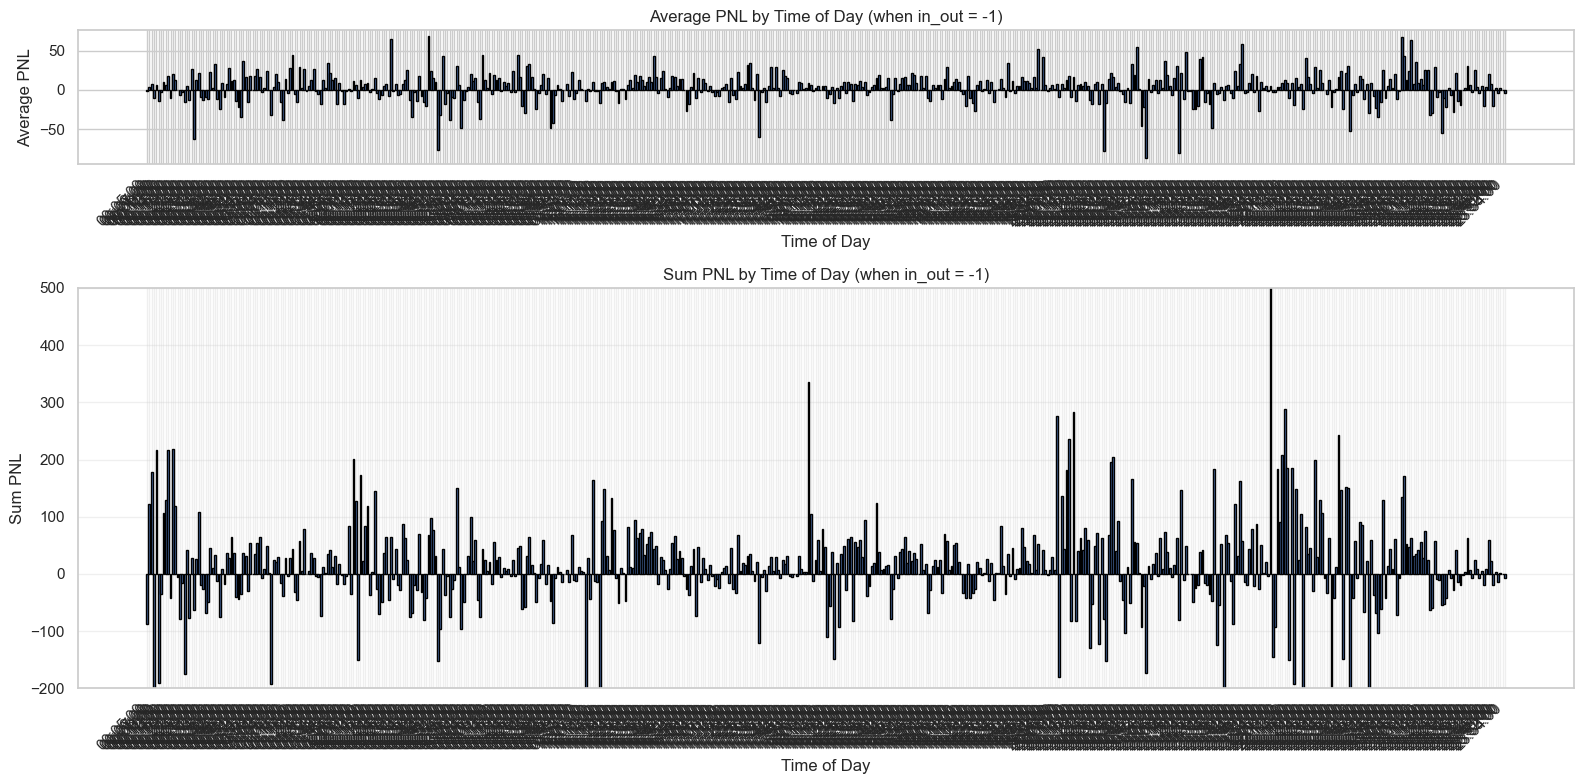

In [53]:
# %matplotlib qt 
%matplotlib inline 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 3]})
# Create a histogram
# plt.figure(figsize=(16, 2))
ax1.bar(average_pnl.index, average_pnl['pnl'], edgecolor='black')
ax1.set_title('Average PNL by Time of Day (when in_out = -1)')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Average PNL')
# Rotate the x-axis tick labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Filter out negative values
# positive_sum_pnl = sum_pnl[sum_pnl['pnl'] > -100]

ax2.bar(sum_pnl.index, sum_pnl['pnl'], edgecolor='black')
ax2.set_title('Sum PNL by Time of Day (when in_out = -1)')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Sum PNL')
# Limit the y-axis range to be larger than -100
ax2.set_ylim(top=500,bottom=-200)
# Set the y-axis to a symmetrical logarithmic scale
# ax2.set_yscale('symlog', linthresh=1)
# Rotate the x-axis tick labels
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

績效回報

In [54]:
#查看最終報酬
earn_point = merged_noVIX_df.tail(1)['margin'].values[0]
profit = earn_point / 3500
print(f"earn_point: {earn_point}")
print(f"profit: {profit * 100:.2f}%")

#計算MDD
margin_history = merged_noVIX_df['margin'].values # array([  nan,   nan,   nan, ..., 1216., 1216., 1216.])
# Remove NaN values
cleaned_margin_history = margin_history[~np.isnan(margin_history)] + 3500 #保證金成本3000
# Calculate the running maximum
running_max = np.maximum.accumulate(cleaned_margin_history)
# Calculate the drawdown
drawdown = (cleaned_margin_history - running_max) / running_max
# Find the maximum drawdown
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# 計算夏普率
# Calculate returns
returns = np.diff(cleaned_margin_history) / cleaned_margin_history[:-1]
# Calculate mean and standard deviation of returns
mean_returns = np.mean(returns)
std_returns = np.std(returns)
# Assuming risk-free rate is 0
risk_free_rate = 0
# Calculate Sharpe ratio
sharpe_ratio_5min = (mean_returns - risk_free_rate) / std_returns
print(f'5 min Sharpe Ratio: {sharpe_ratio_5min}')
# Number of 5-minute intervals in a year
intervals_per_year = 12 * 24 * 250
# Annualized Sharpe ratio
annualized_sharpe_ratio = sharpe_ratio_5min * np.sqrt(intervals_per_year)
print(f'Year Sharpe Ratio: {annualized_sharpe_ratio}')

# 如果不停損 #365
# earn_point: 12799.0
# profit: 365.69%
# Maximum Drawdown: -8.61%
# 5 min Sharpe Ratio: 0.008793977169485743
# Year Sharpe Ratio: 2.851202150350922

# 停損100點 #250
# earn_point: 11524.0
# profit: 329.26%
# Maximum Drawdown: -8.72%
# 5 min Sharpe Ratio: 0.00833767196068416
# Year Sharpe Ratio: 2.237232153382048

earn_point: 12745.0
profit: 364.14%
Maximum Drawdown: -8.62%
5 min Sharpe Ratio: 0.008488275269855947
Year Sharpe Ratio: 2.277643261815392


In [55]:
# 若要儲存回測報告
merged_noVIX_df.to_csv("datas/NQTXF-回測報告_漣漪法.csv")
#2023-01-01 ~ 2024-08-08 共606天 412個交易日

繪圖

In [56]:
# 一致化兩個df的時間 因為有的缺少了
df1 = df_NQTXF
df2 = merged_noVIX_df

# Align indices
common_dates = df1.index.intersection(df2.index)
df_NQTXF_compare = df1.loc[common_dates]
# df2_aligned = df2.loc[common_dates]
# Verify alignment
print(df_NQTXF_compare.index.equals(merged_noVIX_df.index))  # Should print True
# 一致化兩個df的時間 因為有的缺少了

True


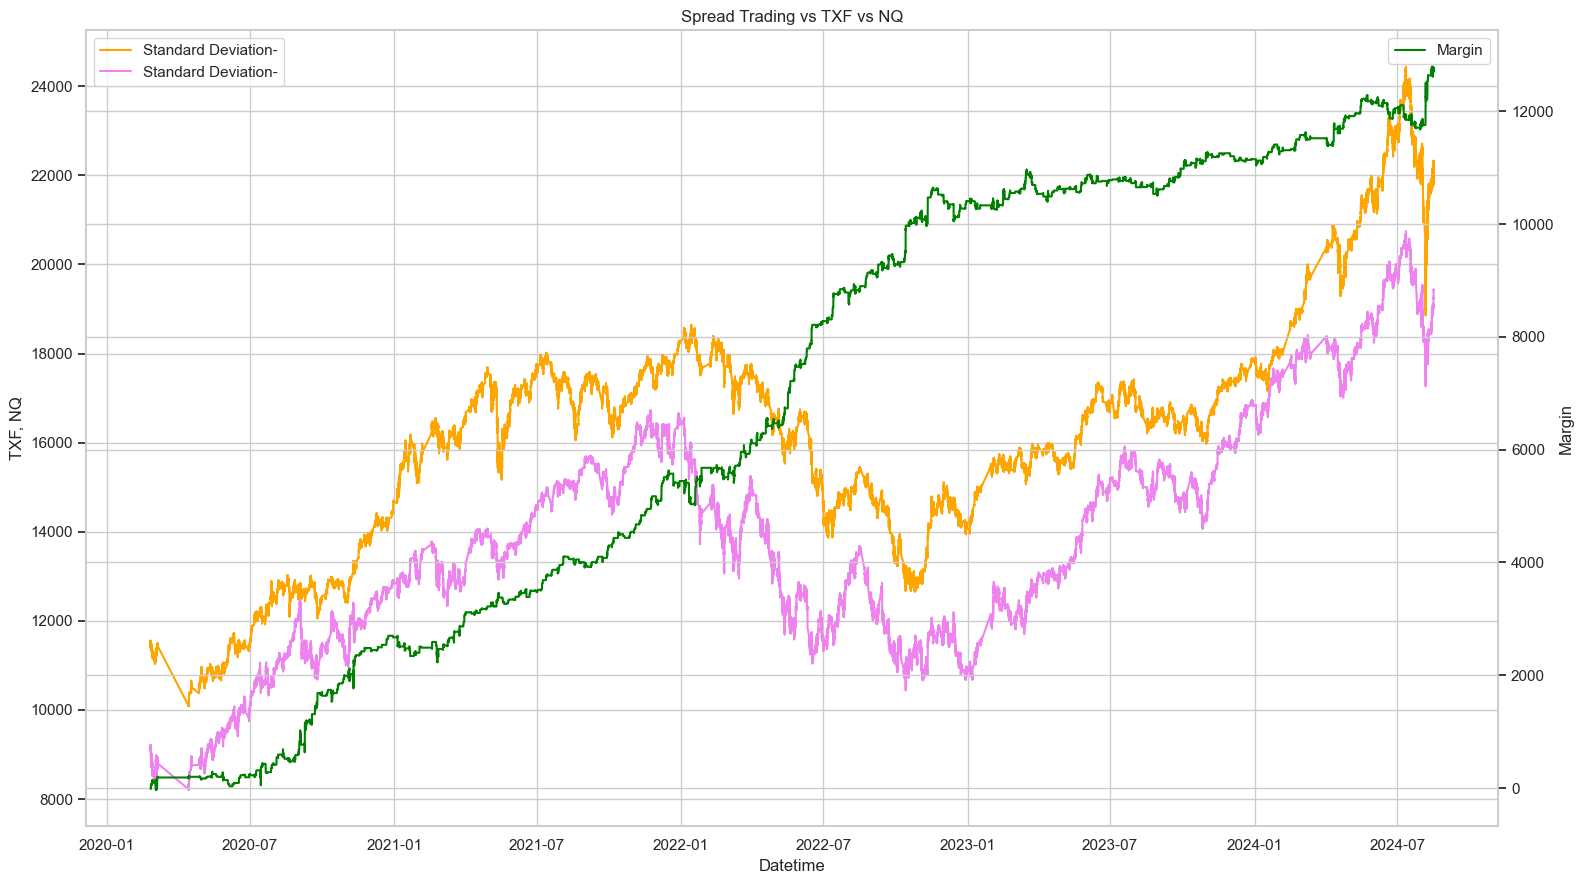

In [57]:
# 與大盤比較圖
# %matplotlib qt 
%matplotlib inline 

# Creating the figure and the first subplot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))


# Plotting the first set of data
ax1.plot(merged_noVIX_df.index, df_NQTXF_compare["Close_TXF"], label='Standard Deviation-', color='orange')
ax1.plot(merged_noVIX_df.index, df_NQTXF_compare["Close_NQ"], label='Standard Deviation-', color='violet')
# Adding titles and labels to the first plot
ax1.set_title('Spread Trading vs TXF vs NQ')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('TXF, NQ')
ax1.legend()

# Creating a second y-axis for the 'margin' data
ax2 = ax1.twinx()
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='Margin', color='green')
# Adding labels to the second y-axis
ax2.set_ylabel('Margin')
ax2.legend(loc='upper right')
plt.grid(True)
# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

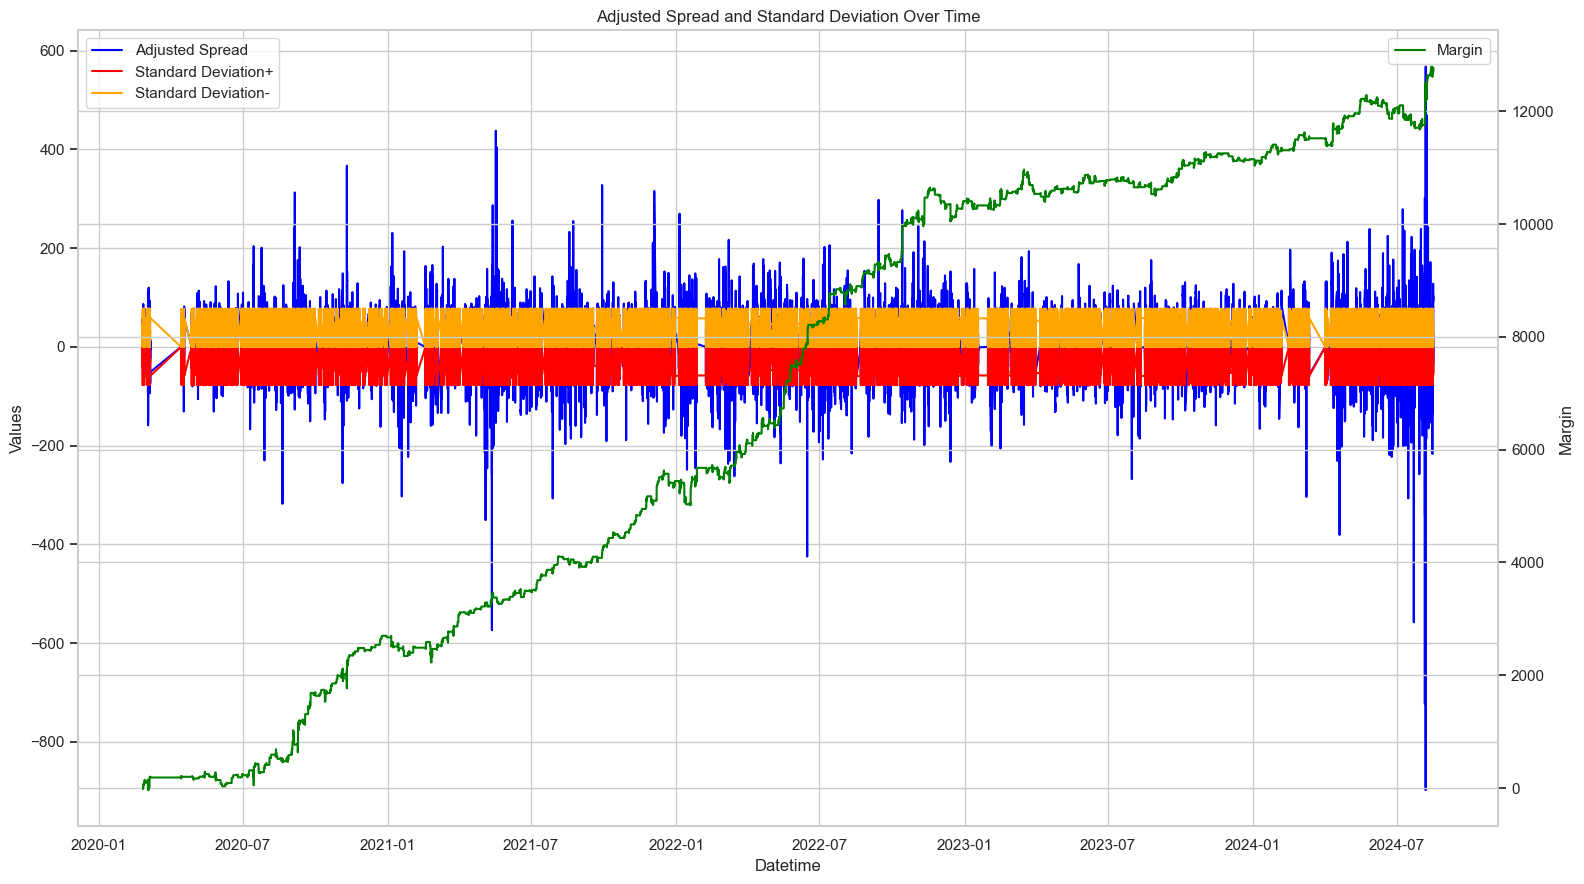

In [58]:
# 單圖
# %matplotlib qt 
%matplotlib inline 

# Creating the figure and the first subplot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))

# Plotting the first set of data
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')

# Adding titles and labels to the first plot
ax1.set_title('Adjusted Spread and Standard Deviation Over Time')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Values')
ax1.legend()

# Creating a second y-axis for the 'margin' data
ax2 = ax1.twinx()
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='Margin', color='green')

# Adding labels to the second y-axis
ax2.set_ylabel('Margin')
ax2.legend(loc='upper right')
plt.grid(True)
# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

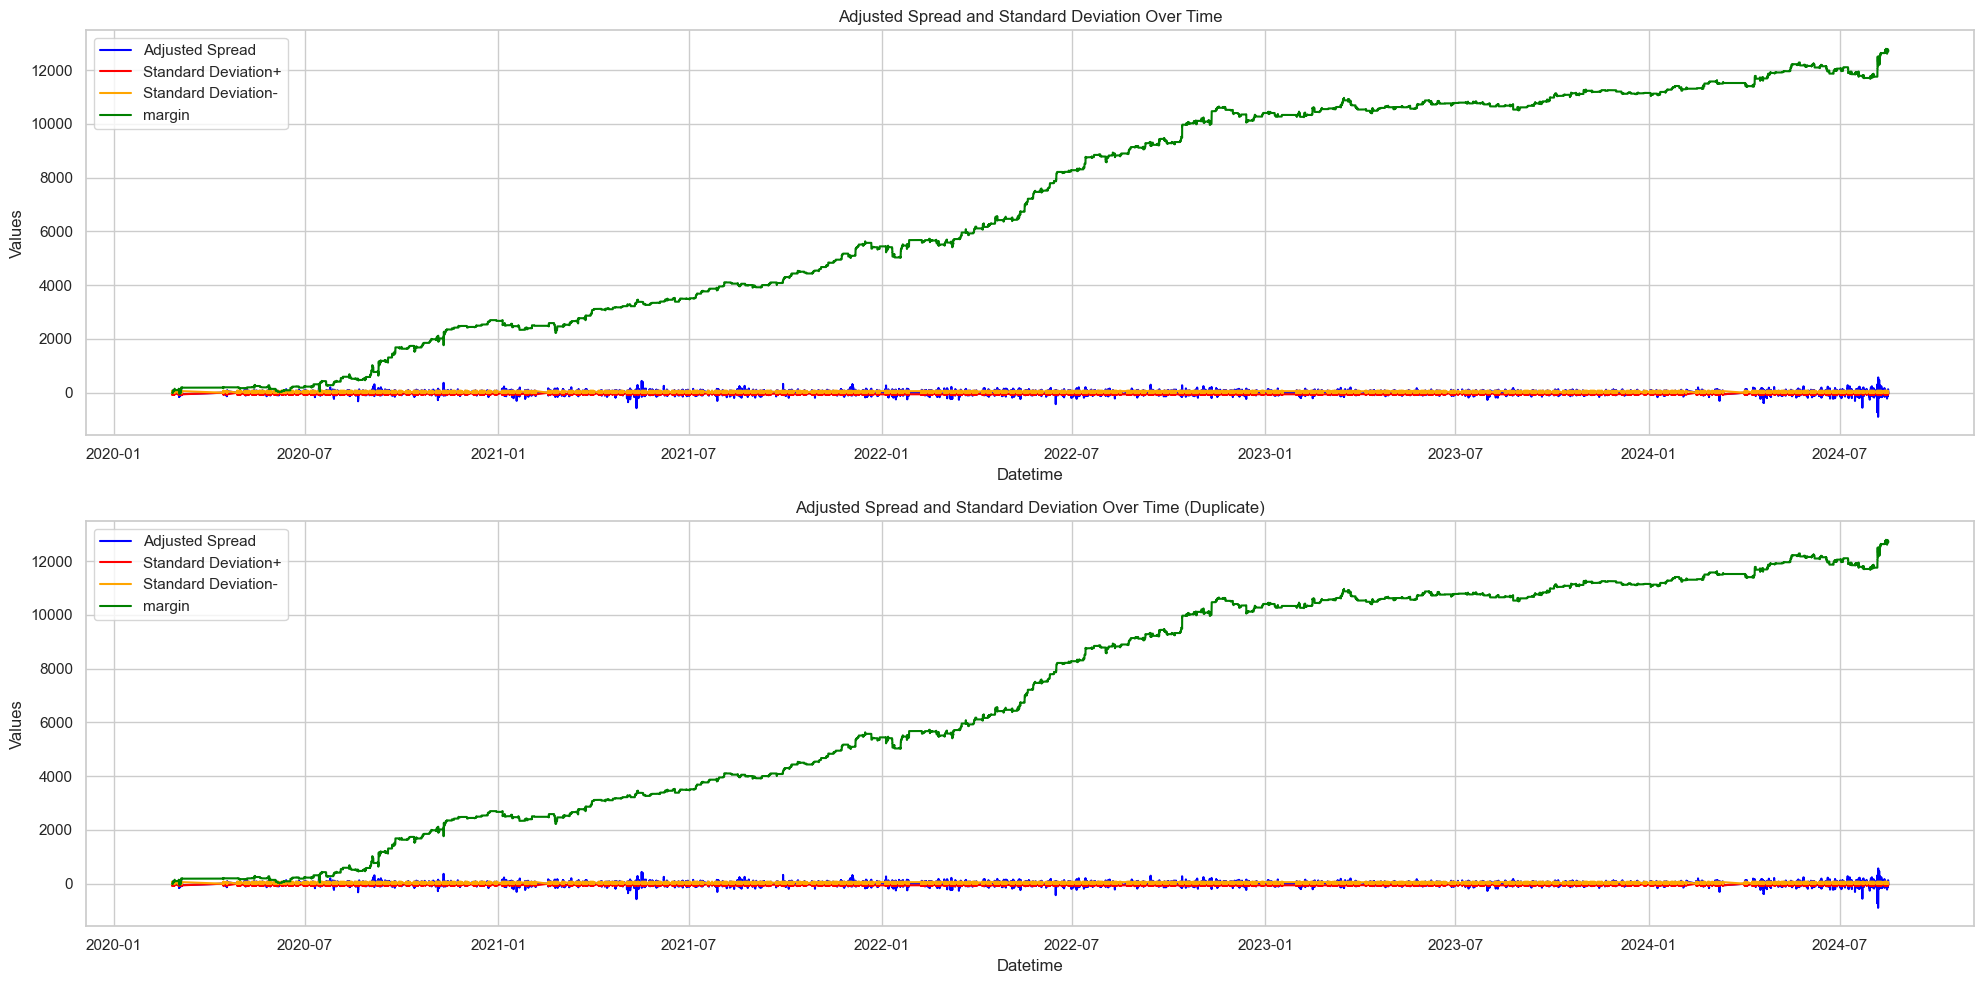

In [59]:
# 雙圖
# %matplotlib qt 
%matplotlib inline 

# Creating the figure and the first subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plotting the first set of data
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='margin', color='green')

# Adding titles and labels to the first plot
ax1.set_title('Adjusted Spread and Standard Deviation Over Time')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Values')
ax1.legend()
plt.grid(True)

# Plotting the second set of data (same as the first for demonstration)
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='margin', color='green')

# Adding titles and labels to the second plot
ax2.set_title('Adjusted Spread and Standard Deviation Over Time (Duplicate)')
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Values')
ax2.legend()
plt.grid(True)


# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()